# 中文长文本分类与推荐（今日头条数据）

jeff

guojianfu@gmail.com

2017.9.30

In [1]:
import string
import re
import time

import pandas as pd
# xlrd is also requried
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from wordcloud import WordCloud
import jieba
import jieba.posseg as pseg

## 1. 数据的import和access

In [2]:
xl = pd.ExcelFile("toutiao.xlsx")
xl.sheet_names

['Sheet1']

In [3]:
df = xl.parse("Sheet1")
print(df.shape)
s=df.head()
s

(13140, 10)


,原创,题目,评论,阅读,日期,时间,类别,URL,正文,标签
0,原,一触即发！美国军方一号进沈阳释放强烈信号,1,15720327,2017-08-18,15:38:45,军事,http://www.toutiao.com/a6455515910357647885/,“如果朝鲜问题将出现一种军事解决方案，那绝对是可怕的。”在美朝口水战空前激烈的背景下，美国参...,美国/朝鲜半岛/陆军/Jeep指挥官/
1,原,印度外交部哀叹，印度没有收到来自中国的洪水数据,31832,6600593,2017-08-19,10:30:13,国际,http://www.toutiao.com/a6455807489534345742/,作者：王德华印度每年6月至9月是季风雨季，雷电暴雨天气频发，洪水及泥石流等灾害经常发生。印度...,布拉马普特拉河/恒河/象泉河/雅鲁藏布江/
2,原,上任仅仨月他已成南海中国神队友，美国下一个天敌？,211,3133985,2017-08-17,16:02:46,国际,http://www.toutiao.com/a6455151014193398286/,东盟外长会结束一周以后，菲律宾又搞出了一个“大动作”。该国外长宣布，将与中国联合勘探南海。看...,南海/东盟/美国/王毅/
3,NaN,「养生堂」今日17：25播出《秋季长寿养生经——打破秋季高发,0,3106659,2017-08-17,13:39:46,健康,http://www.toutiao.com/a6454568844127469837/,NaN,NaN
4,NaN,「养生厨房」今日播出——西红柿烧茄子,0,3105632,2017-08-18,14:23:27,美食,http://www.toutiao.com/a6455273360070574349/,NaN,NaN


In [4]:
st = s.loc[0,'正文']
print(st)

“如果朝鲜问题将出现一种军事解决方案，那绝对是可怕的。”在美朝口水战空前激烈的背景下，美国参谋长联席会议主席约瑟夫·邓福德，近日访问了北部战区司令部驻地沈阳和首都北京。长安街知事App发现，这是美军高层首次参观能近距离监控中朝边境的地区。敏感时期，中国将美国军方一号人物请到沈阳，释放了强烈的信号。真正狠角儿不靠嘴前有二战功勋“五星上将”布莱德雷，后有“太空司令”理查德·迈尔斯——作为美国军方“首长堆儿里的首长”，参联会主席从来不是“软蛋”，现任主席约瑟夫·邓福德更因为在战场上的功绩得到“Fighting Joe，战斗乔”的绰号。不过，正因为军人的身份，美国军方的指挥官们，比五角大楼和白宫的文官说话更靠谱。昨天，邓福德结束了访问解放军北部战区和北京的行程。美联社说，邓福德在北京会见中国军方高层时表达了这样一层意思：如果朝鲜问题将出现一种军事解决方案，那绝对是可怕的，这一点毋庸置疑。“我的意思是，我们有必要制定有效的沟通机制，这样一来，一旦爆发危机，我们能够立即进行对话，避免误判和加剧危机。”有意思的是，邓福德的说法，与美国总统特朗普和防长马蒂斯截然相反，二者曾分别在办公室里向记者咆哮“朝鲜将面临前所未有的炮火与怒火”“一旦美军对朝开展，朝鲜必败”等等。这被媒体广泛解读为，口水战。然而，真正的狠角儿不靠嘴。《华尔街日报》透露，早在特朗普与金正恩口水战升温之前，邓福德的访华计划就已制订。指挥官们“怕”什么？“美国希望金正恩同意实现朝鲜无核化并停止试射导弹。”邓福德在北京说，这是更可取的最终状态。那么，美国指挥官们“怕”什么呢？班农，白宫中少数与军方持相同观点的文官说了实话。这位正逐渐被边缘化的特朗普首席战略分析师说，“对朝鲜，美国不存在军事解决方案，忘了它吧。在有人解开这部分方程式，向我证明首尔的1000万人不会在头30分钟死于常规武器之前，我不知道你在谈论的是什么，这里根本不存在军事解决方案，他们难住了我们。”没错，知事早先分析过，朝鲜真正的王牌并不是那些有的没的核导弹，而是隐藏在三八线群山地下工事中的近千门火炮。一旦朝鲜拼命，这些火炮一轮齐射，就可让距离三八线仅45公里的首尔，瞬间回到30年前，1000多万居民身处火海。美国太平洋舰队司令部有多少航母舰载机，关岛、釜山、横须贺基地有多少弹道导弹，能“先发制人”削平板门店附近的山头呢？如果不能保全首尔，那么特朗普的炮火，

## 2. 分词及分词前的处理

In [5]:
print(string.punctuation)
print('\r')
# m = st.translate(None, string.punctuation)
intab = string.punctuation + '。，“”‘’（）：；？·—《》、'
outtab = ' '
print ("New Dictionary : %s" %  str(dict.fromkeys(intab, outtab)))
table = str.maketrans(dict.fromkeys(intab, outtab))
st1 = st.translate(table)
# 替换掉字符串中的所有character，用正则表达式的话要用\连起来，表示或
st1 = re.sub("\d", " ", st1)
# 用正则表达式替换掉数字

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

New Dictionary : {'!': ' ', '"': ' ', '#': ' ', '$': ' ', '%': ' ', '&': ' ', "'": ' ', '(': ' ', ')': ' ', '*': ' ', '+': ' ', ',': ' ', '-': ' ', '.': ' ', '/': ' ', ':': ' ', ';': ' ', '<': ' ', '=': ' ', '>': ' ', '?': ' ', '@': ' ', '[': ' ', '\\': ' ', ']': ' ', '^': ' ', '_': ' ', '`': ' ', '{': ' ', '|': ' ', '}': ' ', '~': ' ', '。': ' ', '，': ' ', '“': ' ', '”': ' ', '‘': ' ', '’': ' ', '（': ' ', '）': ' ', '：': ' ', '；': ' ', '？': ' ', '·': ' ', '—': ' ', '《': ' ', '》': ' ', '、': ' '}


## 3. Retrieve useful information

In [7]:
from many_stop_words import get_stop_words, available_languages
# available_languages
stopset = get_stop_words('zh')
# type(get_stop_words('zh')), set
print(stopset)
my_stopset = set([' ', '如果', '问题', '将', '时', '更', '正', '说']).union(stopset)

{'后', '跟', '沿', '某', '随', '很', '及', '只', '但', '尔', '把', '吧', '儿', '趁', '当', '该', '啥', '再', '嗡', '们', '从', '今', '他', '咱', '着', '有', '哟', '几', '个', '下', '又', '诸', '它', '并', '另', '打', '起', '向', '得', '怎', '和', '看', '哪', '些', '虽', '仍', '那', '所', '好', '了', '之', '各', '您', '最', '你', '往', '却', '小', '这', '亦', '如', '则', '此', '还', '自', '被', '不', '是', '给', '即', '让', '我', '嘛', '的', '到', '而', '靠', '何', '她', '若', '致', '其', '曾', '据', '来', '因', '或', '凡', '于', '无', '啦', '为', '与', '别', '凭', '同', '人', '使', '乃', '既', '上', '哇', '可', '由', '去', '用', '至', '谁', '距', '以', '比', '也', '且', '么', '拿', '一', '已', '在', '每'}


In [8]:
filter_seg=filter(lambda x: x not in my_stopset and len(x.strip())>0, jieba.cut(st1))

data_tokenized = ' '.join(filter_seg)
print(data_tokenized)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/jd/1z1j_nrj4glfy5lc0l0ld0q00000gn/T/jieba.cache
Loading model cost 1.175 seconds.
Prefix dict has been built succesfully.


朝鲜 出现 一种 军事 解决方案 绝对 可怕 美朝 口水战 空前 激烈 背景 美国参谋长联席会议 主席 约瑟夫 邓福德 近日 访问 北部 战区 司令部 驻地 沈阳 首都北京 长安街 知事 App 发现 这是 美军 高层 首次 参观 能 近距离 监控 中 朝 边境 地区 敏感时期 中国 美国 军方 一号 人物 请 沈阳 释放 强烈 信号 真正 狠 角儿 不靠 嘴前 二战 功勋 五星上将 布莱德雷 太空 司令 理查德 迈尔斯 作为 美国 军方 首长 堆儿 里 首长 参联会 主席 从来不 软蛋 现任 主席 约瑟夫 邓福德 因为 战场 功绩 得到 Fighting Joe 战斗 乔 绰号 不过 因为 军人 身份 美国 军方 指挥官 五角大楼 白宫 文官 说话 谱 昨天 邓福德 结束 访问 解放军 北部 战区 北京 行程 美联社 邓福德 北京 会见 中国军方 高层 表达 这样 一层 意思 朝鲜 出现 一种 军事 解决方案 绝对 可怕 一点 毋庸置疑 意思 我们 必要 制定 有效 沟通 机制 这样一来 一旦 爆发 危机 我们 能够 立即 进行 对话 避免 误判 加剧 危机 有意思 邓福德 说法 美国 总统 特朗普 防长 马蒂斯 截然 相反 二者 分别 办公室 里 记者 咆哮 朝鲜 面临 前所未有 炮火 怒火 一旦 美军 对朝 开展 朝鲜 必败 等等 媒体 广泛 解读 口水战 然而 真正 狠 角儿 不靠 嘴 华尔街日报 透露 早 特朗普 金正恩 口水战 升温 之前 邓福德 访华 计划 就 制订 指挥官 怕 什么 美国 希望 金正恩 同意 实现 朝鲜 无核化 停止 试射 导弹 邓福德 北京 可取 最终 状态 那么 美国 指挥官 怕 什么 呢 班农 白宫 中 少数 军方 持 相同 观点 文官 实话 这位 逐渐 边缘化 特朗普 首席 战略 分析师 对 朝鲜 美国 存在 军事 解决方案 忘 有人 解开 这部分 方程式 证明 首尔 万人 不会 头 分钟 死 常规武器 之前 知道 谈论 什么 这里 根本 存在 军事 解决方案 他们 难住 我们 没错 知事 早先 分析 过 朝鲜 真正 王牌 不是 那些 没 核导弹 而是 隐藏 三八线 群山 地下 工事 中 近 千门 火炮 一旦 朝鲜 拼命 这些 火炮 一轮 齐射 就 距离 三八线 仅 公里 首尔 瞬间 回到 年前 多万 居民 身处 火海 美国 

In [9]:
ws = pseg.cut(st1)
j=0
for i in ws:
    print(i)
    j+=1
    if j>20:
        break

 /x
如果/c
朝鲜/ns
问题/n
将/d
出现/v
一种/m
军事/n
解决方案/n
 /x
那/r
绝对/d
是/v
可怕/c
的/uj
 /x
 /x
在/p
美朝/ns
口水战/n
空前/s


In [11]:
import jieba.analyse
tags = jieba.analyse.extract_tags(st1, topK=100, allowPOS=('n', 'v', 'ns'))
print(' '.join(tags))

朝鲜 美国 军方 危机 解决方案 军事 战区 口水战 中国 沈阳 指挥官 实弹演习 北京 主席 敏感时期 误判 对话 高层 司令部 沟通 角儿 知事 不靠 朝鲜半岛 媒体 爆发 怒火 炮火 文官 会见 参观 首长 边境 火炮 访问 释放 信号 距离 避免 展开 机制 美朝 防长 下于 问题 意思 双方 军事手段 软蛋 横须贺 板门店 进行 核导弹 五角大楼 首都北京 堆儿 难住 边缘化 削平 釜山 长龙 长安街 理查德 齐射 到访 观摩 试射 先发制人 必败 关岛 火海 开火 方程式 军委 提出 王牌 存在 可取 咆哮 地区 功勋 发现 发生 群山 工事 记者 航母 绰号 太空 功绩 保全 没错 弹道导弹 选项 时说 实话 山头 解开 不能 行程


## 4. Missing data

In [12]:
df.isnull().sum()

原创     11536
题目         0
评论         0
阅读         0
日期         0
时间         0
类别       286
URL        0
正文      1467
标签      1614
dtype: int64

In [14]:
data_all = df.dropna(subset=['正文'])
data_all.sort_values(['阅读'], ascending=False)
data_all.head()

,原创,题目,评论,阅读,日期,时间,类别,URL,正文,标签
0,原,一触即发！美国军方一号进沈阳释放强烈信号,1,15720327,2017-08-18,15:38:45,军事,http://www.toutiao.com/a6455515910357647885/,“如果朝鲜问题将出现一种军事解决方案，那绝对是可怕的。”在美朝口水战空前激烈的背景下，美国参...,美国/朝鲜半岛/陆军/Jeep指挥官/
1,原,印度外交部哀叹，印度没有收到来自中国的洪水数据,31832,6600593,2017-08-19,10:30:13,国际,http://www.toutiao.com/a6455807489534345742/,作者：王德华印度每年6月至9月是季风雨季，雷电暴雨天气频发，洪水及泥石流等灾害经常发生。印度...,布拉马普特拉河/恒河/象泉河/雅鲁藏布江/
2,原,上任仅仨月他已成南海中国神队友，美国下一个天敌？,211,3133985,2017-08-17,16:02:46,国际,http://www.toutiao.com/a6455151014193398286/,东盟外长会结束一周以后，菲律宾又搞出了一个“大动作”。该国外长宣布，将与中国联合勘探南海。看...,南海/东盟/美国/王毅/
5,NaN,金正恩身后一张照片，韩国人看得汗毛倒竖,0,3034723,2017-08-17,18:32:44,军事,http://www.toutiao.com/a6455189662217536013/,这是一张含义丰富的照片。”三天前，朝鲜最高领袖金正恩视察战略军司令部，官方发布的照片里赫然出...,金正恩/韩国/舰空导弹/潜地导弹/
6,原,印军紧急征集骆驼：为印度山地军运输弹药 犯了常识性大错,6902,2903172,2017-08-18,17:55:43,军事,http://www.toutiao.com/a6455551209494282766/,骆驼一直都是一种重要的运输工具，尤其是在古代和近代交通不发达的时代和地区。过去，我军也曾经建...,骆驼/动物/交通/直升机/


high指的是二三百万的阅读量，low指的是二三十万的阅读量

In [15]:
data_all.iloc[5:10,:]

,原创,题目,评论,阅读,日期,时间,类别,URL,正文,标签
7,NaN,持刀砍蔡英文卫兵者称要表达“统一”立场 名嘴：想起荆轲刺秦王,15525,2807838,2017-08-19,10:01:31,NaN,http://www.toutiao.com/a6455787475511017998/,（原标题：军刀砍向蔡办 绿色政治仇恨造就的“荆轲刺秦王”？）警方18日侦讯从台军历史文物馆偷...,台湾/日本/政治/文章/
8,原,“太子辉”在酒店有专房接受性服务 觉得好会多给钱,7072,2717138,2017-08-17,22:02:44,社会,http://www.toutiao.com/a6455243777832387086/,西楚网讯 备受关注的东莞太子酒店老板梁耀辉等人组织卖淫罪案近日一审宣判，梁耀辉被判无期徒刑。...,梁耀辉/酒店/桑拿/法律/
9,原,解放战争毛主席最看重这个地区，蒋介石犯一生中最大错误痛失此地,621,2701095,2017-08-17,12:43:17,历史,http://www.toutiao.com/a6455081073033347598/,文｜ 李崇寒1945年8月9日零时10分，苏联百万红军越过中苏、中蒙边境，向日本关东军发起猛...,中国近代史/蒋介石/林彪/军事历史/
10,原,女大学生昆明旅游被打头缝6针，自称不知道为啥会被打,4690,2672324,2017-08-18,17:10:46,社会,http://www.toutiao.com/a6455539622867894797/,8月18日，一个名为“Ophelia之死”的网友在微博上爆料，称其8月17日在昆明旅游时遇袭...,交通/社会/
11,原,军方证实：首艘《战狼2》同款入列东海舰队,3327,2599285,2017-08-17,23:54:23,军事,http://www.toutiao.com/a6455272550829130253/,法制晚报·看法新闻（记者 李文姬 编辑 岳三猛）《解放军报》今日刊文《导弹飞来不会数你肩上的...,海军/驱逐舰/航母/武器/


In [16]:
data_all.iloc[10995:11000,:]

,原创,题目,评论,阅读,日期,时间,类别,URL,正文,标签
12399,NaN,实拍俄罗斯富人的悠闲生活，三亚和越南的海滩都有他们的身影,43,333541,2017-09-14,20:36:49,旅游,http://www.toutiao.com/a6465612023345447438/,俄罗斯富人挺懂得享受的，什么游艇、私人飞机、豪华别墅和兰博基尼跑车已经成为标配。不仅如此，这...,黑海/游艇/兰博基尼/跑车/
12400,NaN,顺产时必须经历的7张图，太尴尬了，这种滋味孕妇终身难忘,503,333354,2017-09-13,13:14:52,育儿,http://www.toutiao.com/a6465126966654665229/,昨天去看望了刚生完宝宝的红红。一见到我，红红就拉着我说：“你知道我昨天怎么生不如死吗？太尴尬...,分娩/产后护理/孕产/育儿/
12401,NaN,46岁孙悦全家近照，一首祝你平安出名，长的丑却没想嫁的那么好,159,332344,2017-09-13,13:08:45,娱乐,http://www.toutiao.com/a6463394555474477582/,祝你平安~祝你平安~，只要是听到这歌词、歌曲总是能够顺口的哼起来，这首孙悦的《祝你平安》当年...,孙悦/韩国/婚姻/李湘/
12403,NaN,单场丢9球的前国门29岁便无奈退役，如今他在卖樱桃！,316,332085,2017-09-15,09:50:40,体育,http://www.toutiao.com/a6465816595636683278/,当37岁的郑智依然在亚冠赛场上打满120分钟并上演人球分过的好戏时，比他还年轻一两岁的“超白...,中国男足/安琦/中甲/足球/
12404,NaN,国产最牛的柴油发动机品牌，一点也不比进口的差,996,331771,2017-09-13,16:31:58,汽车,http://www.toutiao.com/a6465177841351787021/,柴油发动机是燃烧柴油来获取能量释放的发动机。其最大的优点就是功率大、经济性能好。柴油发动机的...,国产车/中国一汽/潍柴动力/环境保护/


## 5. Get word distributions

In [17]:
data_size = 1000
data1 = data_all.iloc[0:data_size,8].tolist()
data2 = data_all.iloc[10000:10000+data_size,8].tolist()
data = [data1, data2]
[len(datum) for datum in data]

[1000, 1000]

In [18]:
def clean_post(post):
    st1 = post.translate(table)
    # 替换掉字符串中的所有character，用正则表达式的话要用\连起来，表示或
    st1 = re.sub("\d", " ", st1)
    # filter_seg=filter(lambda x: x not in my_stopset and len(x.strip())>0, jieba.cut(st1))
    # data_tokenized = ' '.join(filter_seg)
    # tags = jieba.analyse.extract_tags(st1, topK=100, allowPOS=('n', 'v', 'ns'))
    tags = jieba.analyse.extract_tags(st1, topK=100, allowPOS=('n', 'ns'))
    clean = ' '.join(tags)
    # print('clean...\r')
    return clean

In [19]:
t_start = time.time()
data_tokenized = [[clean_post(article) for article in datum] for datum in data]
t_end = time.time()
elapsed_time = float(t_end - t_start)/60
print(elapsed_time)
data_tokenized[0][0]

2.5657281160354612


'朝鲜 美国 军方 危机 解决方案 军事 战区 口水战 中国 沈阳 指挥官 实弹演习 北京 主席 敏感时期 对话 高层 司令部 角儿 朝鲜半岛 媒体 怒火 炮火 文官 会见 参观 首长 边境 火炮 信号 距离 机制 美朝 问题 意思 双方 军事手段 软蛋 横须贺 板门店 核导弹 五角大楼 首都北京 堆儿 边缘化 釜山 长龙 长安街 理查德 先发制人 关岛 火海 方程式 军委 王牌 地区 功勋 群山 工事 记者 航母 绰号 太空 功绩 弹道导弹 选项 时说 山头 行程 现任 舰队 驻地 协商 半岛 司令 军人 二者 军官 韩国 太平洋 交流 首席 战场 身份 办公室 导弹 总统 证明 基地 局面 观点 背景 官员 居民 人物 东北 分析师 战略 部队 状态'

In [20]:
freqs_list = []
for datum in data_tokenized:
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,    
                                 preprocessor = None, stop_words = None, 
                                 max_features = 100)
    this_bow = vectorizer.fit_transform(datum)
    this_bow_array = this_bow.toarray()
    vocabulary = vectorizer.get_feature_names()
    counts = np.sum(this_bow_array, axis = 0)
    top_words = pd.DataFrame({'word': vocabulary, 'count': counts}).sort_values(by = 'count', ascending = False)
    top_series = top_words['count']
    top_series.index = top_words['word']
    freqs_list.append(top_series)

In [21]:
# rel_freq_list = [f / f.sum() for f in freqs_list]
rel_freq_list = [f for f in freqs_list]

In [22]:
all_names = ['high', 'low']
%matplotlib inline
# % means calling a special function
%config InlineBackend.figure_format='retina'
plt.rcParams['font.sans-serif'] = ['SimHei']

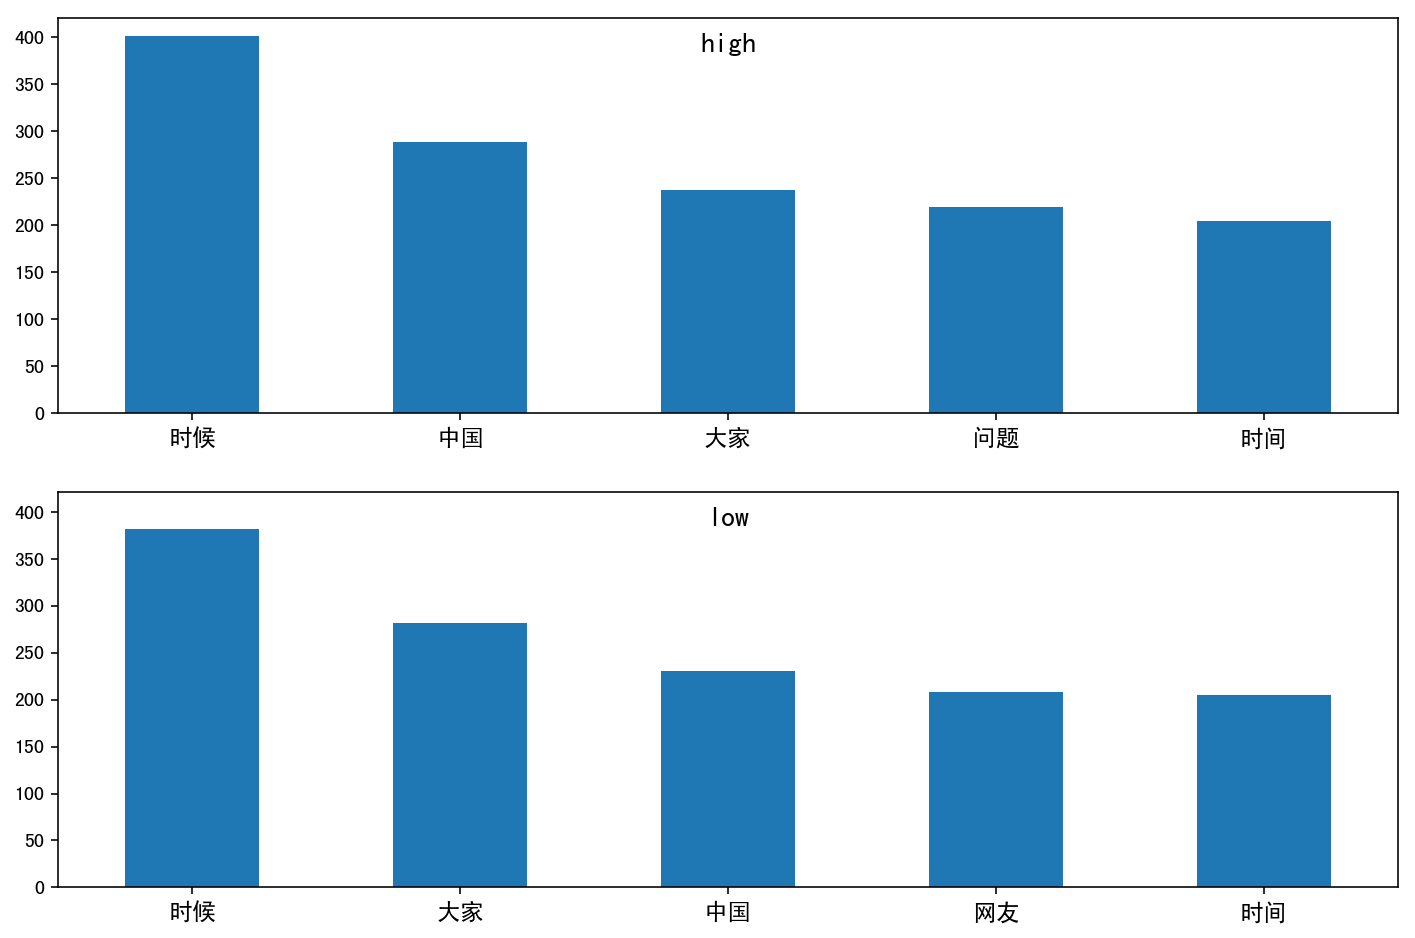

In [25]:
fig, axes = plt.subplots(2, 1, sharex = False, sharey = True, figsize = (12, 8))
cnt = 0
rel_freq_list[cnt][:5].plot.bar(ax = axes[0])
axes[0].set_xticklabels(rel_freq_list[cnt][:5].index.tolist(), rotation = 0, fontsize = 12)
axes[0].set_xlabel("", fontsize = 12)
axes[0].text(0.5, 0.915, all_names[cnt], fontweight = "bold", fontsize = 14, 
                            horizontalalignment = 'center', transform = axes[0].transAxes)
cnt=1
rel_freq_list[cnt][:5].plot.bar(ax = axes[1])
axes[1].set_xticklabels(rel_freq_list[cnt][:5].index.tolist(), rotation = 0, fontsize = 12)
axes[1].set_xlabel("", fontsize = 12)
axes[1].text(0.5, 0.915, all_names[cnt], fontweight = "bold", fontsize = 14, 
                            horizontalalignment = 'center', transform = axes[1].transAxes)
# axes[2].axis('off')
plt.show()

## 6. Word tf-idf

In [26]:
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

high_article = rel_freq_list[0].to_dict()
low_article = rel_freq_list[1].to_dict()

for word in high_article.keys():
    positive_counts[word] = high_article[word]
    total_counts[word] = total_counts[word]+high_article[word]
    
for word in low_article.keys():
    negative_counts[word] = low_article[word]
    total_counts[word] = total_counts[word]+low_article[word]   
    
pos_neg_ratios = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in rel_freq_list[0].to_dict().items():
    if(cnt > 50):
        pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio   
        
pos_neg_ratios.most_common()[0:20]        

[('婆婆', 63.0),
 ('日子', 62.0),
 ('公众', 60.0),
 ('城市', 59.0),
 ('俄罗斯', 58.0),
 ('军事', 57.0),
 ('衣服', 55.0),
 ('年龄', 54.0),
 ('武器', 54.0),
 ('双方', 53.0),
 ('大学', 51.0),
 ('速度', 51.0),
 ('电影', 1.3611111111111112),
 ('技术', 1.3448275862068966),
 ('美国', 1.3027522935779816),
 ('东西', 1.2954545454545454),
 ('妈妈', 1.2835820895522387),
 ('中国', 1.251082251082251),
 ('农村', 1.25),
 ('医院', 1.2295081967213115)]

In [27]:
list(reversed(pos_neg_ratios.most_common()))[0:10]

[('娱乐圈', 0.66990291262135926),
 ('网友', 0.71770334928229662),
 ('照片', 0.77215189873417722),
 ('基本', 0.79411764705882348),
 ('联系', 0.81818181818181823),
 ('粉丝', 0.83333333333333337),
 ('小时', 0.83544303797468356),
 ('大家', 0.83745583038869253),
 ('对方', 0.84057971014492749),
 ('结果', 0.84873949579831931)]

In [28]:
pos_neg_ratios2 = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in rel_freq_list[1].to_dict().items():
    if(cnt > 50):
        pos_neg_ratio2 = negative_counts[term] / float(positive_counts[term]+1)
        pos_neg_ratios2[term] = pos_neg_ratio2
        
pos_neg_ratios2.most_common()[0:20]

[('事件', 71.0),
 ('手机', 69.0),
 ('评论', 68.0),
 ('夫妻', 63.0),
 ('现场', 62.0),
 ('形象', 56.0),
 ('国际', 56.0),
 ('人家', 55.0),
 ('方法', 54.0),
 ('时代', 53.0),
 ('企业', 51.0),
 ('效果', 51.0),
 ('娱乐圈', 1.4571428571428571),
 ('网友', 1.3774834437086092),
 ('照片', 1.2580645161290323),
 ('基本', 1.2181818181818183),
 ('大家', 1.1848739495798319),
 ('联系', 1.1818181818181819),
 ('粉丝', 1.1666666666666667),
 ('小时', 1.164179104477612)]

## 7. 云图

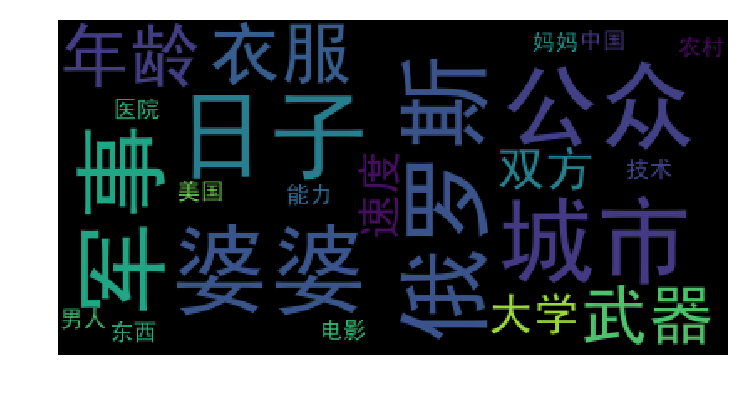

In [30]:
temp = [(term, cnt) for term, cnt in pos_neg_ratios.most_common() if cnt>1.2]
frequencies = {term:cnt for term, cnt in temp}
wordcloud = WordCloud(font_path="simhei.ttf").fit_words(frequencies)

# Display the generated image:
# the matplotlib way:
# import matplotlib.pyplot as plt

# plt.rcParams['font.sans-serif'] = ['SimHei']  # for Chinese characters
# STIXSizOneSymBol, STIXGeneral
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

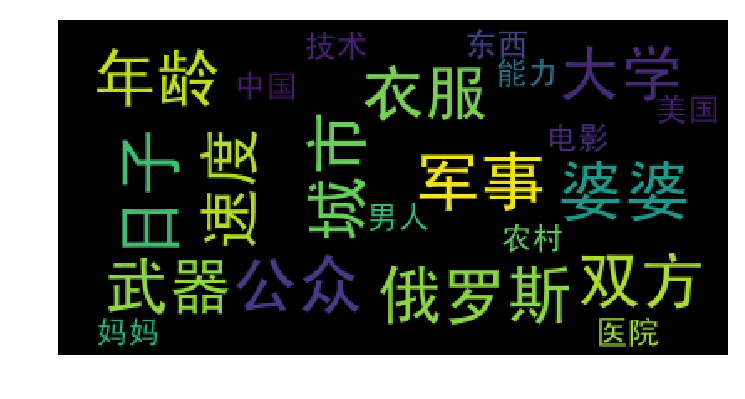

In [31]:
wordcloud = WordCloud(font_path="simhei.ttf", max_font_size=40, relative_scaling=.5).fit_words(frequencies)
# simhei.ttf要放在和该.ipynb文件相同的目录中
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

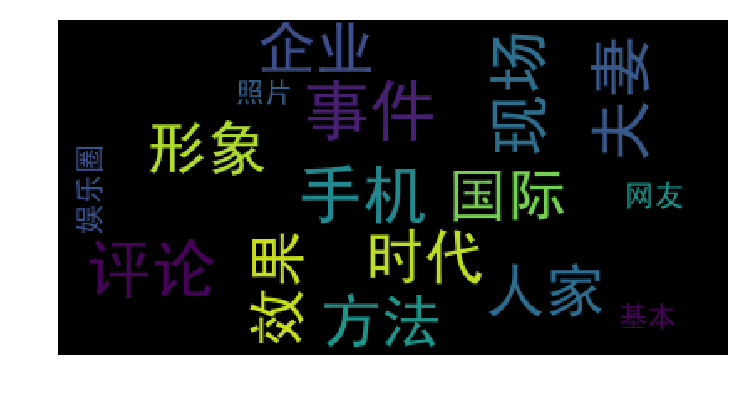

In [32]:
temp3 = [(term, cnt) for term, cnt in pos_neg_ratios2.most_common() if cnt>1.2]
frequencies = {term:cnt for term, cnt in temp3}
wordcloud = WordCloud(font_path="simhei.ttf", max_font_size=40, relative_scaling=.5).fit_words(frequencies)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()